In [68]:
!pip install transformers datasets torch tqdm

In [69]:
import torch
import huggingface_hub
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTModel
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Compose
import pandas as pd
from torch import nn
from torchvision.datasets import ImageFolder
from torch.optim import AdamW
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Subset
import numpy as np

In [70]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])


In [71]:
dataset = ImageFolder(root='/kaggle/input/medical-waste/Medical Waste 4.0 (Previous group)', transform=transform)
dataset_classes = dataset.classes

def my_collate_fn(batch):
    # Manually handle variable sizes by padding or other means
    # For simplicity, we're just showing an example where you might need this
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    # Implement resizing or padding here if needed
    images = torch.stack([transforms.Resize((224, 224))(image) for image in images])
    labels = torch.tensor(labels)
    return images, labels


# Dictionnaire pour stocker les index des échantillons par classe
class_indices = {class_name: [] for class_name in classes}

# Parcourir le dataset pour obtenir les index des échantillons de chaque classe
for index, (image, label) in enumerate(dataset):
    class_indices[classes[label]].append(index)

# Diviser les index en ensembles d'entraînement, de validation et de test
train_indices = []
val_indices = []
test_indices = []

for class_name, indices in class_indices.items():
    # Mélanger les index pour une répartition aléatoire
    np.random.shuffle(indices)

    # Calculer le nombre d'échantillons pour chaque ensemble
    num_samples = len(indices)
    train_size = int(0.7 * num_samples)
    val_size = int(0.15 * num_samples)
    test_size = num_samples - (train_size + val_size)

    # Répartir les index dans les ensembles
    train_indices.extend(indices[:train_size])
    val_indices.extend(indices[train_size:train_size + val_size])
    test_indices.extend(indices[train_size + val_size:])

# Créer les ensembles d'entraînement, de validation et de test
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)



val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=my_collate_fn)

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [73]:
from transformers import ViTForImageClassification
from torch import nn

class CustomViTForImageClassification(nn.Module):
    def __init__(self, num_labels):
        super(CustomViTForImageClassification, self).__init__()
        # Load the base model without the classification head
        self.base_model = ViTModel.from_pretrained('google/vit-base-patch16-224')

        # Freezing the parameters of the base model
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Adding new layers that will be fine-tuned
        self.dropout = nn.Dropout(0.5)
        self.intermediate = nn.Linear(768, 512)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(512, num_labels)

        # These new layers will have requires_grad=True by default

    def forward(self, pixel_values):
        # Use the base model to compute the initial outputs
        outputs = self.base_model(pixel_values)
        # Use the last hidden state
        x = outputs.last_hidden_state[:, 0]  # Assuming you want the first token (like [CLS] in BERT)
        x = self.dropout(x)
        x = self.intermediate(x)
        x = self.relu(x)
        x = self.classifier(x)
        return x

# Assuming you have a defined dataset and device setup
num_labels = len(dataset.classes)  # Make sure 'dataset.classes' is defined as per your dataset
model = CustomViTForImageClassification(num_labels=num_labels)
model.to(device)  # Ensure model is on the right device


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomViTForImageClassification(
  (base_model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(

In [74]:
def test_model_on_test_dataset (models_test_metrics, data_quantity, actual_model):

    def eval_model(model, data_loader, loss_fn, device):
        model.eval()
        losses = []
        correct_predictions = 0
        predictions = []
        actuals = []
        with torch.no_grad():
            for d in data_loader:
                inputs, labels = d[0].to(device), d[1].to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, dim=1)
                loss = loss_fn(outputs, labels)
                correct_predictions += torch.sum(preds == labels).item()  # Convert to Python int immediately
                losses.append(loss.item())  # Convert to Python float immediately
                predictions.extend(preds.cpu().numpy())  # Move predictions to CPU and convert to numpy array
                actuals.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy array

        total_correct = correct_predictions  # This is already a Python scalar
        total = len(data_loader.dataset)
        total_loss = sum(losses)
        test_acc = total_correct / total
        test_loss = total_loss / len(losses)

        return test_acc, test_loss, predictions, actuals


    # Example setup (replace with your actual setup)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Assuming 'test_loader' is already defined
    test_acc, test_loss, predictions, actuals = eval_model(actual_model, test_loader, loss_fn, device)
    models_test_metrics.append({'data_quantity': data_quantity, 'test_accuracy': test_acc, 'test_loss': test_loss})

    # Print the results
    print(f"Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.2f}")


In [75]:


Number_of_samples_per_class = []

def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    for d in tqdm(data_loader):
        inputs, labels = d[0].to(device), d[1].to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)  # Assuming 'outputs' are logits
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return correct_predictions.double() / len(data_loader.dataset), sum(losses) / len(losses)

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            inputs, labels = d[0].to(device), d[1].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)  # Assuming 'outputs' are logits
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / len(data_loader.dataset), sum(losses) / len(losses)


loss_fn = torch.nn.CrossEntropyLoss()
metrics = []

def train_model_with_portions(dataset_portion, data_quantity, classes= dataset_classes):
    
    # Assuming you've defined and loaded your custom model as 'model'
    model = CustomViTForImageClassification(num_labels=len(dataset.classes))
    model.to(device)  # Ensure model is on the right device


    # Setup optimizer - Only optimize the parameters of the new layers
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5)
    
    class_counts = {"Data Quantity": data_quantity}

    
    for index in range(len(dataset_portion)):
        # Access the target class index directly from the item tuple
        _, class_idx = dataset_portion[index]
        # Convert class index to class name using the passed classes array
        class_name = classes[class_idx]

        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1

    # Append the dictionary of counts to the global list
    Number_of_samples_per_class.append(class_counts)
    print(Number_of_samples_per_class)
    
    # Ensure the DataLoader uses a collate function that correctly handles the dataset.
    train_loader = DataLoader(dataset_portion, batch_size=16, shuffle=True, collate_fn=my_collate_fn)


    
    for epoch in range(10):
        train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
        val_acc, val_loss = eval_model(model, val_loader, loss_fn, device)
        metrics.append({'data_quantity': data_quantity,'epoch': epoch+1, 'train_accuracy': train_acc, 'train_loss': train_loss,
                        'val_accuracy': val_acc, 'val_loss': val_loss})
        print(f"Data Quantity {data_quantity} ,Epoch {epoch+1}, Train Acc: {train_acc}, Train Loss: {train_loss}, Val Acc: {val_acc}, Val Loss: {val_loss}")
        
        
    model_name = f'vit_model_freezed_params_10_epochs_model_{data_quantity}_data_quantity.pth'
    path = f'/kaggle/working/{model_name}'
    torch.save(model.state_dict(), path)
    
    test_model_on_test_dataset(models_test_metrics, data_quantity, model)
    
    

In [76]:
def create_balanced_subsets(dataset):
    # Nombre total d'étapes
    num_steps = 10

    # Dictionnaire pour stocker les index des échantillons par classe
    class_indices_train = {class_name: [] for class_name in classes}

    # Parcourir le dataset pour obtenir les index des échantillons de chaque classe
    for index, (image, label) in enumerate(train_dataset):
        class_indices_train[classes[label]].append(index)

    # Calculer le nombre total d'échantillons par classe et le nombre minimum d'échantillons par classe
    total_samples_per_class = {class_name: len(indices) for class_name, indices in class_indices_train.items()}
    min_samples_per_class = min(total_samples_per_class.values())

    # Liste pour stocker les datasets progressifs
    progressive_datasets = []

    # Pour chaque étape
    for step in range(1, num_steps):
         # Créer un dictionnaire pour stocker les indices des échantillons à ajouter à chaque classe
        indices_to_add_per_class = {class_name: [] for class_name in classes}

        # Pour chaque classe
        for class_name, indices in class_indices_train.items():
            # Déterminer le nombre d'échantillons à ajouter pour cette classe à cette étape
            target_num_samples = int(min_samples_per_class * (step / num_steps))

            # Sélectionner les indices des échantillons à ajouter à cette classe
            indices_to_add = indices[:target_num_samples]

            # Ajouter les indices sélectionnés à la liste des indices à ajouter pour cette classe
            indices_to_add_per_class[class_name].extend(indices_to_add)
            
            print(class_name, '--->', len(indices_to_add_per_class[class_name]))

        # Concaténer tous les indices à ajouter pour former le nouvel ensemble de données progressif à cette étape
        progressive_indices = sum(indices_to_add_per_class.values(), [])

        # Créer un Subset à partir du train_dataset avec les indices mis à jour
        progressive_dataset = Subset(train_dataset, progressive_indices)

        # Ajouter le Subset à la liste des datasets progressifs
        progressive_datasets.append(progressive_dataset)

    progressive_datasets.append(train_dataset)
    
    return progressive_datasets


In [77]:
models_test_metrics = []

data_subsets = create_balanced_subsets(train_dataset)

for index, subset in enumerate(data_subsets):
    percentage_string = f"{(index + 1) * 10}%"
    train_model_with_portions(subset, percentage_string)
    
    


# Convert metrics to DataFrame and save as CSV
df = pd.DataFrame(metrics)
df_test_metrics = pd.DataFrame(models_test_metrics)
df_num_sample_per_class_for_percentage = pd.DataFrame(Number_of_samples_per_class)
df.to_csv('/kaggle/working/training_validation_metrics_different_data_quantity_ViT_freezed_params.csv', index=False)
df_test_metrics.to_csv('/kaggle/working/test_metrics_different_data_quantity_ViT_freezed_params.csv', index=False)
df_num_sample_per_class_for_percentage.to_csv('/kaggle/working/num_sample_per_class_for_percentage_data_quantity_Vit_freezed_params_10_epochs', index=False)

gauze ---> 21
glove_pair_latex ---> 21
glove_pair_nitrile ---> 21
glove_pair_surgery ---> 21
glove_single_latex ---> 21
glove_single_nitrile ---> 21
glove_single_surgery ---> 21
medical_cap ---> 21
medical_glasses ---> 21
shoe_cover_pair ---> 21
shoe_cover_single ---> 21
test_tube ---> 21
urine_bag ---> 21
gauze ---> 42
glove_pair_latex ---> 42
glove_pair_nitrile ---> 42
glove_pair_surgery ---> 42
glove_single_latex ---> 42
glove_single_nitrile ---> 42
glove_single_surgery ---> 42
medical_cap ---> 42
medical_glasses ---> 42
shoe_cover_pair ---> 42
shoe_cover_single ---> 42
test_tube ---> 42
urine_bag ---> 42
gauze ---> 63
glove_pair_latex ---> 63
glove_pair_nitrile ---> 63
glove_pair_surgery ---> 63
glove_single_latex ---> 63
glove_single_nitrile ---> 63
glove_single_surgery ---> 63
medical_cap ---> 63
medical_glasses ---> 63
shoe_cover_pair ---> 63
shoe_cover_single ---> 63
test_tube ---> 63
urine_bag ---> 63
gauze ---> 84
glove_pair_latex ---> 84
glove_pair_nitrile ---> 84
glove_pair

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'Data Quantity': '10%', 'gauze': 21, 'glove_pair_latex': 21, 'glove_pair_nitrile': 21, 'glove_pair_surgery': 21, 'glove_single_latex': 21, 'glove_single_nitrile': 21, 'glove_single_surgery': 21, 'medical_cap': 21, 'medical_glasses': 21, 'shoe_cover_pair': 21, 'shoe_cover_single': 21, 'test_tube': 21, 'urine_bag': 21}]


100%|██████████| 18/18 [00:06<00:00,  2.98it/s]


Data Quantity 10% ,Epoch 1, Train Acc: 0.10256410256410256, Train Loss: 2.56953321562873, Val Acc: 0.19395866454689986, Val Loss: 2.4671529054641725


100%|██████████| 18/18 [00:05<00:00,  3.04it/s]


Data Quantity 10% ,Epoch 2, Train Acc: 0.18681318681318682, Train Loss: 2.4185355769263372, Val Acc: 0.36565977742448336, Val Loss: 2.346597123146057


100%|██████████| 18/18 [00:05<00:00,  3.04it/s]


Data Quantity 10% ,Epoch 3, Train Acc: 0.3333333333333333, Train Loss: 2.320756951967875, Val Acc: 0.4912559618441972, Val Loss: 2.234249544143677


100%|██████████| 18/18 [00:05<00:00,  3.06it/s]


Data Quantity 10% ,Epoch 4, Train Acc: 0.43956043956043955, Train Loss: 2.1602149142159357, Val Acc: 0.5834658187599364, Val Loss: 2.1284162044525146


100%|██████████| 18/18 [00:06<00:00,  2.99it/s]


Data Quantity 10% ,Epoch 5, Train Acc: 0.5311355311355311, Train Loss: 2.0492209593454995, Val Acc: 0.6152623211446742, Val Loss: 2.023442232608795


100%|██████████| 18/18 [00:05<00:00,  3.06it/s]


Data Quantity 10% ,Epoch 6, Train Acc: 0.5641025641025641, Train Loss: 1.9545878767967224, Val Acc: 0.6756756756756758, Val Loss: 1.918325662612915


100%|██████████| 18/18 [00:05<00:00,  3.08it/s]


Data Quantity 10% ,Epoch 7, Train Acc: 0.6593406593406593, Train Loss: 1.8172434568405151, Val Acc: 0.7027027027027027, Val Loss: 1.8183678150177003


100%|██████████| 18/18 [00:05<00:00,  3.01it/s]


Data Quantity 10% ,Epoch 8, Train Acc: 0.717948717948718, Train Loss: 1.720948146449195, Val Acc: 0.7122416534181241, Val Loss: 1.719176435470581


100%|██████████| 18/18 [00:05<00:00,  3.06it/s]


Data Quantity 10% ,Epoch 9, Train Acc: 0.7289377289377289, Train Loss: 1.6301462319162157, Val Acc: 0.7408585055643879, Val Loss: 1.6246000170707702


100%|██████████| 18/18 [00:05<00:00,  3.06it/s]


Data Quantity 10% ,Epoch 10, Train Acc: 0.8095238095238095, Train Loss: 1.516267630789015, Val Acc: 0.7551669316375199, Val Loss: 1.5313915610313416
Test Accuracy: 0.78, Test Loss: 1.46


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'Data Quantity': '10%', 'gauze': 21, 'glove_pair_latex': 21, 'glove_pair_nitrile': 21, 'glove_pair_surgery': 21, 'glove_single_latex': 21, 'glove_single_nitrile': 21, 'glove_single_surgery': 21, 'medical_cap': 21, 'medical_glasses': 21, 'shoe_cover_pair': 21, 'shoe_cover_single': 21, 'test_tube': 21, 'urine_bag': 21}, {'Data Quantity': '20%', 'gauze': 42, 'glove_pair_latex': 42, 'glove_pair_nitrile': 42, 'glove_pair_surgery': 42, 'glove_single_latex': 42, 'glove_single_nitrile': 42, 'glove_single_surgery': 42, 'medical_cap': 42, 'medical_glasses': 42, 'shoe_cover_pair': 42, 'shoe_cover_single': 42, 'test_tube': 42, 'urine_bag': 42}]


100%|██████████| 35/35 [00:12<00:00,  2.91it/s]


Data Quantity 20% ,Epoch 1, Train Acc: 0.163003663003663, Train Loss: 2.494189739227295, Val Acc: 0.40540540540540543, Val Loss: 2.3295859336853026


100%|██████████| 35/35 [00:11<00:00,  2.98it/s]


Data Quantity 20% ,Epoch 2, Train Acc: 0.36813186813186816, Train Loss: 2.267787081854684, Val Acc: 0.6311605723370429, Val Loss: 2.106059956550598


100%|██████████| 35/35 [00:11<00:00,  2.96it/s]


Data Quantity 20% ,Epoch 3, Train Acc: 0.5457875457875457, Train Loss: 2.0391766582216535, Val Acc: 0.6899841017488076, Val Loss: 1.8860181093215942


100%|██████████| 35/35 [00:11<00:00,  2.95it/s]


Data Quantity 20% ,Epoch 4, Train Acc: 0.6666666666666666, Train Loss: 1.8065003326960973, Val Acc: 0.7519872813990461, Val Loss: 1.6626567125320435


100%|██████████| 35/35 [00:11<00:00,  2.93it/s]


Data Quantity 20% ,Epoch 5, Train Acc: 0.7234432234432234, Train Loss: 1.602322200366429, Val Acc: 0.7519872813990461, Val Loss: 1.4541450798511506


100%|██████████| 35/35 [00:11<00:00,  2.99it/s]


Data Quantity 20% ,Epoch 6, Train Acc: 0.7527472527472527, Train Loss: 1.410275684084211, Val Acc: 0.7885532591414944, Val Loss: 1.273206067085266


100%|██████████| 35/35 [00:12<00:00,  2.91it/s]


Data Quantity 20% ,Epoch 7, Train Acc: 0.7857142857142857, Train Loss: 1.2370162504059927, Val Acc: 0.7853736089030208, Val Loss: 1.1287966668605804


100%|██████████| 35/35 [00:11<00:00,  2.94it/s]


Data Quantity 20% ,Epoch 8, Train Acc: 0.8168498168498168, Train Loss: 1.1049661891801017, Val Acc: 0.8060413354531002, Val Loss: 1.0064553022384644


100%|██████████| 35/35 [00:11<00:00,  2.95it/s]


Data Quantity 20% ,Epoch 9, Train Acc: 0.8241758241758241, Train Loss: 0.9648745775222778, Val Acc: 0.8012718600953895, Val Loss: 0.9138936430215836


100%|██████████| 35/35 [00:12<00:00,  2.81it/s]


Data Quantity 20% ,Epoch 10, Train Acc: 0.8333333333333334, Train Loss: 0.8785913177898952, Val Acc: 0.8251192368839428, Val Loss: 0.8304769366979599
Test Accuracy: 0.85, Test Loss: 0.76


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'Data Quantity': '10%', 'gauze': 21, 'glove_pair_latex': 21, 'glove_pair_nitrile': 21, 'glove_pair_surgery': 21, 'glove_single_latex': 21, 'glove_single_nitrile': 21, 'glove_single_surgery': 21, 'medical_cap': 21, 'medical_glasses': 21, 'shoe_cover_pair': 21, 'shoe_cover_single': 21, 'test_tube': 21, 'urine_bag': 21}, {'Data Quantity': '20%', 'gauze': 42, 'glove_pair_latex': 42, 'glove_pair_nitrile': 42, 'glove_pair_surgery': 42, 'glove_single_latex': 42, 'glove_single_nitrile': 42, 'glove_single_surgery': 42, 'medical_cap': 42, 'medical_glasses': 42, 'shoe_cover_pair': 42, 'shoe_cover_single': 42, 'test_tube': 42, 'urine_bag': 42}, {'Data Quantity': '30%', 'gauze': 63, 'glove_pair_latex': 63, 'glove_pair_nitrile': 63, 'glove_pair_surgery': 63, 'glove_single_latex': 63, 'glove_single_nitrile': 63, 'glove_single_surgery': 63, 'medical_cap': 63, 'medical_glasses': 63, 'shoe_cover_pair': 63, 'shoe_cover_single': 63, 'test_tube': 63, 'urine_bag': 63}]


100%|██████████| 52/52 [00:17<00:00,  2.94it/s]


Data Quantity 30% ,Epoch 1, Train Acc: 0.22832722832722832, Train Loss: 2.438354721436134, Val Acc: 0.507154213036566, Val Loss: 2.210600709915161


100%|██████████| 52/52 [00:17<00:00,  2.97it/s]


Data Quantity 30% ,Epoch 2, Train Acc: 0.5152625152625152, Train Loss: 2.0798278015393477, Val Acc: 0.6979332273449921, Val Loss: 1.8647634267807007


100%|██████████| 52/52 [00:17<00:00,  2.95it/s]


Data Quantity 30% ,Epoch 3, Train Acc: 0.6239316239316239, Train Loss: 1.7762590875992408, Val Acc: 0.7567567567567568, Val Loss: 1.5392404794692993


100%|██████████| 52/52 [00:17<00:00,  2.95it/s]


Data Quantity 30% ,Epoch 4, Train Acc: 0.7191697191697192, Train Loss: 1.476797035107246, Val Acc: 0.7933227344992051, Val Loss: 1.2589319586753844


100%|██████████| 52/52 [00:17<00:00,  2.93it/s]


Data Quantity 30% ,Epoch 5, Train Acc: 0.7448107448107448, Train Loss: 1.2321820373718555, Val Acc: 0.8060413354531002, Val Loss: 1.0428769528865813


100%|██████████| 52/52 [00:17<00:00,  2.97it/s]


Data Quantity 30% ,Epoch 6, Train Acc: 0.8070818070818071, Train Loss: 1.0225420571290529, Val Acc: 0.809220985691574, Val Loss: 0.8809606820344925


100%|██████████| 52/52 [00:17<00:00,  2.94it/s]


Data Quantity 30% ,Epoch 7, Train Acc: 0.8522588522588522, Train Loss: 0.882171862400495, Val Acc: 0.8314785373608904, Val Loss: 0.7650049060583115


100%|██████████| 52/52 [00:17<00:00,  2.96it/s]


Data Quantity 30% ,Epoch 8, Train Acc: 0.8400488400488401, Train Loss: 0.7654137324828368, Val Acc: 0.8441971383147854, Val Loss: 0.6780018091201783


100%|██████████| 52/52 [00:17<00:00,  2.94it/s]


Data Quantity 30% ,Epoch 9, Train Acc: 0.8693528693528694, Train Loss: 0.6644112559465262, Val Acc: 0.8521462639109698, Val Loss: 0.6123173266649247


100%|██████████| 52/52 [00:17<00:00,  2.96it/s]


Data Quantity 30% ,Epoch 10, Train Acc: 0.8644688644688645, Train Loss: 0.609089949956307, Val Acc: 0.8426073131955485, Val Loss: 0.5624233067035675
Test Accuracy: 0.87, Test Loss: 0.51


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'Data Quantity': '10%', 'gauze': 21, 'glove_pair_latex': 21, 'glove_pair_nitrile': 21, 'glove_pair_surgery': 21, 'glove_single_latex': 21, 'glove_single_nitrile': 21, 'glove_single_surgery': 21, 'medical_cap': 21, 'medical_glasses': 21, 'shoe_cover_pair': 21, 'shoe_cover_single': 21, 'test_tube': 21, 'urine_bag': 21}, {'Data Quantity': '20%', 'gauze': 42, 'glove_pair_latex': 42, 'glove_pair_nitrile': 42, 'glove_pair_surgery': 42, 'glove_single_latex': 42, 'glove_single_nitrile': 42, 'glove_single_surgery': 42, 'medical_cap': 42, 'medical_glasses': 42, 'shoe_cover_pair': 42, 'shoe_cover_single': 42, 'test_tube': 42, 'urine_bag': 42}, {'Data Quantity': '30%', 'gauze': 63, 'glove_pair_latex': 63, 'glove_pair_nitrile': 63, 'glove_pair_surgery': 63, 'glove_single_latex': 63, 'glove_single_nitrile': 63, 'glove_single_surgery': 63, 'medical_cap': 63, 'medical_glasses': 63, 'shoe_cover_pair': 63, 'shoe_cover_single': 63, 'test_tube': 63, 'urine_bag': 63}, {'Data Quantity': '40%', 'gauze': 84

100%|██████████| 69/69 [00:23<00:00,  2.94it/s]


Data Quantity 40% ,Epoch 1, Train Acc: 0.2619047619047619, Train Loss: 2.3850384207739346, Val Acc: 0.5723370429252782, Val Loss: 2.100242185592651


100%|██████████| 69/69 [00:23<00:00,  2.90it/s]


Data Quantity 40% ,Epoch 2, Train Acc: 0.5521978021978022, Train Loss: 1.935930407565573, Val Acc: 0.7186009538950716, Val Loss: 1.6432820439338685


100%|██████████| 69/69 [00:24<00:00,  2.79it/s]


Data Quantity 40% ,Epoch 3, Train Acc: 0.7152014652014652, Train Loss: 1.5211898157562034, Val Acc: 0.7519872813990461, Val Loss: 1.2616039097309113


100%|██████████| 69/69 [00:24<00:00,  2.81it/s]


Data Quantity 40% ,Epoch 4, Train Acc: 0.7518315018315018, Train Loss: 1.2057343306748762, Val Acc: 0.809220985691574, Val Loss: 0.987270075082779


100%|██████████| 69/69 [00:23<00:00,  2.92it/s]


Data Quantity 40% ,Epoch 5, Train Acc: 0.8177655677655677, Train Loss: 0.9525828292404396, Val Acc: 0.836248012718601, Val Loss: 0.8069974720478058


100%|██████████| 69/69 [00:23<00:00,  2.91it/s]


Data Quantity 40% ,Epoch 6, Train Acc: 0.8278388278388278, Train Loss: 0.7973725778469141, Val Acc: 0.8585055643879174, Val Loss: 0.683196160197258


100%|██████████| 69/69 [00:23<00:00,  2.92it/s]


Data Quantity 40% ,Epoch 7, Train Acc: 0.8608058608058609, Train Loss: 0.6683239798614944, Val Acc: 0.863275039745628, Val Loss: 0.5987428322434425


100%|██████████| 69/69 [00:23<00:00,  2.92it/s]


Data Quantity 40% ,Epoch 8, Train Acc: 0.8543956043956044, Train Loss: 0.5959233015343763, Val Acc: 0.8696343402225756, Val Loss: 0.5317326128482819


100%|██████████| 69/69 [00:23<00:00,  2.95it/s]


Data Quantity 40% ,Epoch 9, Train Acc: 0.8836996336996337, Train Loss: 0.5247245292732681, Val Acc: 0.8680445151033387, Val Loss: 0.4883784309029579


100%|██████████| 69/69 [00:23<00:00,  2.95it/s]


Data Quantity 40% ,Epoch 10, Train Acc: 0.8937728937728938, Train Loss: 0.48324600466783496, Val Acc: 0.891891891891892, Val Loss: 0.4471090048551559
Test Accuracy: 0.89, Test Loss: 0.40


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'Data Quantity': '10%', 'gauze': 21, 'glove_pair_latex': 21, 'glove_pair_nitrile': 21, 'glove_pair_surgery': 21, 'glove_single_latex': 21, 'glove_single_nitrile': 21, 'glove_single_surgery': 21, 'medical_cap': 21, 'medical_glasses': 21, 'shoe_cover_pair': 21, 'shoe_cover_single': 21, 'test_tube': 21, 'urine_bag': 21}, {'Data Quantity': '20%', 'gauze': 42, 'glove_pair_latex': 42, 'glove_pair_nitrile': 42, 'glove_pair_surgery': 42, 'glove_single_latex': 42, 'glove_single_nitrile': 42, 'glove_single_surgery': 42, 'medical_cap': 42, 'medical_glasses': 42, 'shoe_cover_pair': 42, 'shoe_cover_single': 42, 'test_tube': 42, 'urine_bag': 42}, {'Data Quantity': '30%', 'gauze': 63, 'glove_pair_latex': 63, 'glove_pair_nitrile': 63, 'glove_pair_surgery': 63, 'glove_single_latex': 63, 'glove_single_nitrile': 63, 'glove_single_surgery': 63, 'medical_cap': 63, 'medical_glasses': 63, 'shoe_cover_pair': 63, 'shoe_cover_single': 63, 'test_tube': 63, 'urine_bag': 63}, {'Data Quantity': '40%', 'gauze': 84

100%|██████████| 86/86 [00:29<00:00,  2.89it/s]


Data Quantity 50% ,Epoch 1, Train Acc: 0.29304029304029305, Train Loss: 2.3091580049936162, Val Acc: 0.6327503974562798, Val Loss: 1.971373987197876


100%|██████████| 86/86 [00:29<00:00,  2.89it/s]


Data Quantity 50% ,Epoch 2, Train Acc: 0.6483516483516484, Train Loss: 1.7532923193865044, Val Acc: 0.7662957074721781, Val Loss: 1.4193235099315644


100%|██████████| 86/86 [00:29<00:00,  2.91it/s]


Data Quantity 50% ,Epoch 3, Train Acc: 0.736996336996337, Train Loss: 1.3010963658953822, Val Acc: 0.7965023847376789, Val Loss: 1.0270753085613251


100%|██████████| 86/86 [00:29<00:00,  2.94it/s]


Data Quantity 50% ,Epoch 4, Train Acc: 0.8051282051282052, Train Loss: 0.9616195760494055, Val Acc: 0.8124006359300477, Val Loss: 0.7909738659858704


100%|██████████| 86/86 [00:29<00:00,  2.91it/s]


Data Quantity 50% ,Epoch 5, Train Acc: 0.8373626373626374, Train Loss: 0.762408233659212, Val Acc: 0.8330683624801273, Val Loss: 0.6537134170532226


100%|██████████| 86/86 [00:29<00:00,  2.92it/s]


Data Quantity 50% ,Epoch 6, Train Acc: 0.8483516483516483, Train Loss: 0.6286958925599275, Val Acc: 0.8282988871224166, Val Loss: 0.5639355421066284


100%|██████████| 86/86 [00:29<00:00,  2.93it/s]


Data Quantity 50% ,Epoch 7, Train Acc: 0.8717948717948718, Train Loss: 0.5410478740584018, Val Acc: 0.8521462639109698, Val Loss: 0.4898561596870422


100%|██████████| 86/86 [00:29<00:00,  2.92it/s]


Data Quantity 50% ,Epoch 8, Train Acc: 0.882051282051282, Train Loss: 0.4858349315648855, Val Acc: 0.863275039745628, Val Loss: 0.4458500578999519


100%|██████████| 86/86 [00:29<00:00,  2.89it/s]


Data Quantity 50% ,Epoch 9, Train Acc: 0.9010989010989011, Train Loss: 0.42236550464186556, Val Acc: 0.8728139904610493, Val Loss: 0.4080832198262215


100%|██████████| 86/86 [00:29<00:00,  2.89it/s]


Data Quantity 50% ,Epoch 10, Train Acc: 0.9062271062271062, Train Loss: 0.39991539560778194, Val Acc: 0.8744038155802862, Val Loss: 0.38116053193807603
Test Accuracy: 0.90, Test Loss: 0.33


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'Data Quantity': '10%', 'gauze': 21, 'glove_pair_latex': 21, 'glove_pair_nitrile': 21, 'glove_pair_surgery': 21, 'glove_single_latex': 21, 'glove_single_nitrile': 21, 'glove_single_surgery': 21, 'medical_cap': 21, 'medical_glasses': 21, 'shoe_cover_pair': 21, 'shoe_cover_single': 21, 'test_tube': 21, 'urine_bag': 21}, {'Data Quantity': '20%', 'gauze': 42, 'glove_pair_latex': 42, 'glove_pair_nitrile': 42, 'glove_pair_surgery': 42, 'glove_single_latex': 42, 'glove_single_nitrile': 42, 'glove_single_surgery': 42, 'medical_cap': 42, 'medical_glasses': 42, 'shoe_cover_pair': 42, 'shoe_cover_single': 42, 'test_tube': 42, 'urine_bag': 42}, {'Data Quantity': '30%', 'gauze': 63, 'glove_pair_latex': 63, 'glove_pair_nitrile': 63, 'glove_pair_surgery': 63, 'glove_single_latex': 63, 'glove_single_nitrile': 63, 'glove_single_surgery': 63, 'medical_cap': 63, 'medical_glasses': 63, 'shoe_cover_pair': 63, 'shoe_cover_single': 63, 'test_tube': 63, 'urine_bag': 63}, {'Data Quantity': '40%', 'gauze': 84

100%|██████████| 103/103 [00:38<00:00,  2.64it/s]


Data Quantity 60% ,Epoch 1, Train Acc: 0.33943833943833945, Train Loss: 2.2661053694567634, Val Acc: 0.7281399046104929, Val Loss: 1.8436545729637146


100%|██████████| 103/103 [00:37<00:00,  2.75it/s]


Data Quantity 60% ,Epoch 2, Train Acc: 0.6593406593406593, Train Loss: 1.613279879671856, Val Acc: 0.8124006359300477, Val Loss: 1.2242616295814515


100%|██████████| 103/103 [00:35<00:00,  2.89it/s]


Data Quantity 60% ,Epoch 3, Train Acc: 0.7673992673992674, Train Loss: 1.115860703500729, Val Acc: 0.8155802861685215, Val Loss: 0.8594820976257325


100%|██████████| 103/103 [00:35<00:00,  2.92it/s]


Data Quantity 60% ,Epoch 4, Train Acc: 0.8296703296703297, Train Loss: 0.8112989750880639, Val Acc: 0.8600953895071543, Val Loss: 0.6604148596525192


100%|██████████| 103/103 [00:35<00:00,  2.89it/s]


Data Quantity 60% ,Epoch 5, Train Acc: 0.8583638583638583, Train Loss: 0.6450644436391811, Val Acc: 0.8537360890302067, Val Loss: 0.5475961059331894


100%|██████████| 103/103 [00:35<00:00,  2.94it/s]


Data Quantity 60% ,Epoch 6, Train Acc: 0.8772893772893773, Train Loss: 0.5431222825953104, Val Acc: 0.8648648648648649, Val Loss: 0.480501689016819


100%|██████████| 103/103 [00:36<00:00,  2.86it/s]


Data Quantity 60% ,Epoch 7, Train Acc: 0.8742368742368742, Train Loss: 0.47937268814415607, Val Acc: 0.8744038155802862, Val Loss: 0.42313494607806207


100%|██████████| 103/103 [00:36<00:00,  2.83it/s]


Data Quantity 60% ,Epoch 8, Train Acc: 0.9084249084249084, Train Loss: 0.40675818674194003, Val Acc: 0.8759936406995231, Val Loss: 0.3854806661605835


100%|██████████| 103/103 [00:36<00:00,  2.85it/s]


Data Quantity 60% ,Epoch 9, Train Acc: 0.9010989010989011, Train Loss: 0.384498919532137, Val Acc: 0.891891891891892, Val Loss: 0.353573652356863


100%|██████████| 103/103 [00:35<00:00,  2.91it/s]


Data Quantity 60% ,Epoch 10, Train Acc: 0.9114774114774115, Train Loss: 0.33585742434251653, Val Acc: 0.8903020667726551, Val Loss: 0.33170792907476426
Test Accuracy: 0.91, Test Loss: 0.29


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'Data Quantity': '10%', 'gauze': 21, 'glove_pair_latex': 21, 'glove_pair_nitrile': 21, 'glove_pair_surgery': 21, 'glove_single_latex': 21, 'glove_single_nitrile': 21, 'glove_single_surgery': 21, 'medical_cap': 21, 'medical_glasses': 21, 'shoe_cover_pair': 21, 'shoe_cover_single': 21, 'test_tube': 21, 'urine_bag': 21}, {'Data Quantity': '20%', 'gauze': 42, 'glove_pair_latex': 42, 'glove_pair_nitrile': 42, 'glove_pair_surgery': 42, 'glove_single_latex': 42, 'glove_single_nitrile': 42, 'glove_single_surgery': 42, 'medical_cap': 42, 'medical_glasses': 42, 'shoe_cover_pair': 42, 'shoe_cover_single': 42, 'test_tube': 42, 'urine_bag': 42}, {'Data Quantity': '30%', 'gauze': 63, 'glove_pair_latex': 63, 'glove_pair_nitrile': 63, 'glove_pair_surgery': 63, 'glove_single_latex': 63, 'glove_single_nitrile': 63, 'glove_single_surgery': 63, 'medical_cap': 63, 'medical_glasses': 63, 'shoe_cover_pair': 63, 'shoe_cover_single': 63, 'test_tube': 63, 'urine_bag': 63}, {'Data Quantity': '40%', 'gauze': 84

100%|██████████| 120/120 [00:40<00:00,  2.93it/s]


Data Quantity 70% ,Epoch 1, Train Acc: 0.38252223966509685, Train Loss: 2.194665726025899, Val Acc: 0.7122416534181241, Val Loss: 1.732417345046997


100%|██████████| 120/120 [00:40<00:00,  2.94it/s]


Data Quantity 70% ,Epoch 2, Train Acc: 0.7027734170591314, Train Loss: 1.4755626231431962, Val Acc: 0.8076311605723371, Val Loss: 1.0852211594581604


100%|██████████| 120/120 [00:40<00:00,  2.94it/s]


Data Quantity 70% ,Epoch 3, Train Acc: 0.7755102040816327, Train Loss: 0.9921902015805244, Val Acc: 0.8251192368839428, Val Loss: 0.7537929862737656


100%|██████████| 120/120 [00:40<00:00,  2.94it/s]


Data Quantity 70% ,Epoch 4, Train Acc: 0.826268969126112, Train Loss: 0.7324071583648523, Val Acc: 0.8569157392686805, Val Loss: 0.585652582347393


100%|██████████| 120/120 [00:40<00:00,  2.94it/s]


Data Quantity 70% ,Epoch 5, Train Acc: 0.8618524332810048, Train Loss: 0.5854694550236066, Val Acc: 0.8616852146263911, Val Loss: 0.49048025608062745


100%|██████████| 120/120 [00:40<00:00,  2.93it/s]


Data Quantity 70% ,Epoch 6, Train Acc: 0.8765044479330194, Train Loss: 0.4923935701449712, Val Acc: 0.8887122416534182, Val Loss: 0.42582317590713503


100%|██████████| 120/120 [00:40<00:00,  2.95it/s]


Data Quantity 70% ,Epoch 7, Train Acc: 0.8901098901098902, Train Loss: 0.43425498753786085, Val Acc: 0.8839427662957076, Val Loss: 0.38270355984568594


100%|██████████| 120/120 [00:40<00:00,  2.96it/s]


Data Quantity 70% ,Epoch 8, Train Acc: 0.8969126111983255, Train Loss: 0.3802359335124493, Val Acc: 0.8998410174880763, Val Loss: 0.35026349648833277


100%|██████████| 120/120 [00:41<00:00,  2.91it/s]


Data Quantity 70% ,Epoch 9, Train Acc: 0.9105180533751963, Train Loss: 0.35032855595151585, Val Acc: 0.891891891891892, Val Loss: 0.3252710089087486


100%|██████████| 120/120 [00:41<00:00,  2.90it/s]


Data Quantity 70% ,Epoch 10, Train Acc: 0.9047619047619048, Train Loss: 0.3263726521283388, Val Acc: 0.9093799682034976, Val Loss: 0.29663631059229373
Test Accuracy: 0.91, Test Loss: 0.27


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'Data Quantity': '10%', 'gauze': 21, 'glove_pair_latex': 21, 'glove_pair_nitrile': 21, 'glove_pair_surgery': 21, 'glove_single_latex': 21, 'glove_single_nitrile': 21, 'glove_single_surgery': 21, 'medical_cap': 21, 'medical_glasses': 21, 'shoe_cover_pair': 21, 'shoe_cover_single': 21, 'test_tube': 21, 'urine_bag': 21}, {'Data Quantity': '20%', 'gauze': 42, 'glove_pair_latex': 42, 'glove_pair_nitrile': 42, 'glove_pair_surgery': 42, 'glove_single_latex': 42, 'glove_single_nitrile': 42, 'glove_single_surgery': 42, 'medical_cap': 42, 'medical_glasses': 42, 'shoe_cover_pair': 42, 'shoe_cover_single': 42, 'test_tube': 42, 'urine_bag': 42}, {'Data Quantity': '30%', 'gauze': 63, 'glove_pair_latex': 63, 'glove_pair_nitrile': 63, 'glove_pair_surgery': 63, 'glove_single_latex': 63, 'glove_single_nitrile': 63, 'glove_single_surgery': 63, 'medical_cap': 63, 'medical_glasses': 63, 'shoe_cover_pair': 63, 'shoe_cover_single': 63, 'test_tube': 63, 'urine_bag': 63}, {'Data Quantity': '40%', 'gauze': 84

100%|██████████| 137/137 [00:46<00:00,  2.96it/s]


Data Quantity 80% ,Epoch 1, Train Acc: 0.38003663003663, Train Loss: 2.2023672996646297, Val Acc: 0.6820349761526232, Val Loss: 1.6936860799789428


100%|██████████| 137/137 [00:46<00:00,  2.93it/s]


Data Quantity 80% ,Epoch 2, Train Acc: 0.7037545787545788, Train Loss: 1.4038932945606482, Val Acc: 0.7965023847376789, Val Loss: 1.001154500246048


100%|██████████| 137/137 [00:46<00:00,  2.95it/s]


Data Quantity 80% ,Epoch 3, Train Acc: 0.799908424908425, Train Loss: 0.8977323239737184, Val Acc: 0.8473767885532592, Val Loss: 0.6850823298096657


100%|██████████| 137/137 [00:46<00:00,  2.95it/s]


Data Quantity 80% ,Epoch 4, Train Acc: 0.8415750915750916, Train Loss: 0.6705853251645165, Val Acc: 0.8664546899841018, Val Loss: 0.5365099772810936


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Data Quantity 80% ,Epoch 5, Train Acc: 0.8695054945054945, Train Loss: 0.5263106059418977, Val Acc: 0.8696343402225756, Val Loss: 0.4487951330840588


100%|██████████| 137/137 [00:46<00:00,  2.96it/s]


Data Quantity 80% ,Epoch 6, Train Acc: 0.8782051282051282, Train Loss: 0.45185262073565574, Val Acc: 0.8823529411764707, Val Loss: 0.3932447776198387


100%|██████████| 137/137 [00:46<00:00,  2.96it/s]


Data Quantity 80% ,Epoch 7, Train Acc: 0.8965201465201466, Train Loss: 0.3997601554559095, Val Acc: 0.891891891891892, Val Loss: 0.3520758248865604


100%|██████████| 137/137 [00:46<00:00,  2.95it/s]


Data Quantity 80% ,Epoch 8, Train Acc: 0.9120879120879121, Train Loss: 0.34832972331638756, Val Acc: 0.8934817170111289, Val Loss: 0.31987114921212195


100%|██████████| 137/137 [00:46<00:00,  2.94it/s]


Data Quantity 80% ,Epoch 9, Train Acc: 0.9143772893772893, Train Loss: 0.3153155982276819, Val Acc: 0.9093799682034976, Val Loss: 0.3020641278475523


100%|██████████| 137/137 [00:46<00:00,  2.95it/s]


Data Quantity 80% ,Epoch 10, Train Acc: 0.9212454212454212, Train Loss: 0.2940770275618908, Val Acc: 0.9141494435612083, Val Loss: 0.27097185552120207
Test Accuracy: 0.93, Test Loss: 0.24


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'Data Quantity': '10%', 'gauze': 21, 'glove_pair_latex': 21, 'glove_pair_nitrile': 21, 'glove_pair_surgery': 21, 'glove_single_latex': 21, 'glove_single_nitrile': 21, 'glove_single_surgery': 21, 'medical_cap': 21, 'medical_glasses': 21, 'shoe_cover_pair': 21, 'shoe_cover_single': 21, 'test_tube': 21, 'urine_bag': 21}, {'Data Quantity': '20%', 'gauze': 42, 'glove_pair_latex': 42, 'glove_pair_nitrile': 42, 'glove_pair_surgery': 42, 'glove_single_latex': 42, 'glove_single_nitrile': 42, 'glove_single_surgery': 42, 'medical_cap': 42, 'medical_glasses': 42, 'shoe_cover_pair': 42, 'shoe_cover_single': 42, 'test_tube': 42, 'urine_bag': 42}, {'Data Quantity': '30%', 'gauze': 63, 'glove_pair_latex': 63, 'glove_pair_nitrile': 63, 'glove_pair_surgery': 63, 'glove_single_latex': 63, 'glove_single_nitrile': 63, 'glove_single_surgery': 63, 'medical_cap': 63, 'medical_glasses': 63, 'shoe_cover_pair': 63, 'shoe_cover_single': 63, 'test_tube': 63, 'urine_bag': 63}, {'Data Quantity': '40%', 'gauze': 84

100%|██████████| 154/154 [00:52<00:00,  2.93it/s]


Data Quantity 90% ,Epoch 1, Train Acc: 0.4306064306064306, Train Loss: 2.111390039518282, Val Acc: 0.7742448330683626, Val Loss: 1.5242455005645752


100%|██████████| 154/154 [00:52<00:00,  2.92it/s]


Data Quantity 90% ,Epoch 2, Train Acc: 0.7562067562067561, Train Loss: 1.2492992572196118, Val Acc: 0.8267090620031797, Val Loss: 0.8551241159439087


100%|██████████| 154/154 [00:52<00:00,  2.93it/s]


Data Quantity 90% ,Epoch 3, Train Acc: 0.818070818070818, Train Loss: 0.7958701152306098, Val Acc: 0.863275039745628, Val Loss: 0.5940661668777466


100%|██████████| 154/154 [00:52<00:00,  2.94it/s]


Data Quantity 90% ,Epoch 4, Train Acc: 0.8563288563288562, Train Loss: 0.5910533308595806, Val Acc: 0.8759936406995231, Val Loss: 0.47626918405294416


100%|██████████| 154/154 [00:52<00:00,  2.94it/s]


Data Quantity 90% ,Epoch 5, Train Acc: 0.8705738705738706, Train Loss: 0.4796185282530723, Val Acc: 0.8839427662957076, Val Loss: 0.4006851091980934


100%|██████████| 154/154 [00:52<00:00,  2.94it/s]


Data Quantity 90% ,Epoch 6, Train Acc: 0.8852258852258852, Train Loss: 0.4058221633751671, Val Acc: 0.8982511923688394, Val Loss: 0.35283593758940696


100%|██████████| 154/154 [00:52<00:00,  2.95it/s]


Data Quantity 90% ,Epoch 7, Train Acc: 0.9039479039479039, Train Loss: 0.36056817419730225, Val Acc: 0.9014308426073132, Val Loss: 0.32013026624917984


100%|██████████| 154/154 [00:52<00:00,  2.94it/s]


Data Quantity 90% ,Epoch 8, Train Acc: 0.9067969067969067, Train Loss: 0.32559539619591327, Val Acc: 0.9077901430842608, Val Loss: 0.2932602733373642


100%|██████████| 154/154 [00:52<00:00,  2.94it/s]


Data Quantity 90% ,Epoch 9, Train Acc: 0.9165649165649166, Train Loss: 0.29406994561870375, Val Acc: 0.9173290937996821, Val Loss: 0.2712736792862415


100%|██████████| 154/154 [00:52<00:00,  2.92it/s]


Data Quantity 90% ,Epoch 10, Train Acc: 0.9226699226699226, Train Loss: 0.270516327739536, Val Acc: 0.9268680445151034, Val Loss: 0.2506452951580286
Test Accuracy: 0.93, Test Loss: 0.22


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'Data Quantity': '10%', 'gauze': 21, 'glove_pair_latex': 21, 'glove_pair_nitrile': 21, 'glove_pair_surgery': 21, 'glove_single_latex': 21, 'glove_single_nitrile': 21, 'glove_single_surgery': 21, 'medical_cap': 21, 'medical_glasses': 21, 'shoe_cover_pair': 21, 'shoe_cover_single': 21, 'test_tube': 21, 'urine_bag': 21}, {'Data Quantity': '20%', 'gauze': 42, 'glove_pair_latex': 42, 'glove_pair_nitrile': 42, 'glove_pair_surgery': 42, 'glove_single_latex': 42, 'glove_single_nitrile': 42, 'glove_single_surgery': 42, 'medical_cap': 42, 'medical_glasses': 42, 'shoe_cover_pair': 42, 'shoe_cover_single': 42, 'test_tube': 42, 'urine_bag': 42}, {'Data Quantity': '30%', 'gauze': 63, 'glove_pair_latex': 63, 'glove_pair_nitrile': 63, 'glove_pair_surgery': 63, 'glove_single_latex': 63, 'glove_single_nitrile': 63, 'glove_single_surgery': 63, 'medical_cap': 63, 'medical_glasses': 63, 'shoe_cover_pair': 63, 'shoe_cover_single': 63, 'test_tube': 63, 'urine_bag': 63}, {'Data Quantity': '40%', 'gauze': 84

100%|██████████| 186/186 [01:03<00:00,  2.95it/s]


Data Quantity 100% ,Epoch 1, Train Acc: 0.4691607684529828, Train Loss: 1.9985412134919116, Val Acc: 0.7774244833068363, Val Loss: 1.3335137963294983


100%|██████████| 186/186 [01:03<00:00,  2.93it/s]


Data Quantity 100% ,Epoch 2, Train Acc: 0.7687900235928548, Train Loss: 1.0749674016429531, Val Acc: 0.836248012718601, Val Loss: 0.7293447375297546


100%|██████████| 186/186 [01:04<00:00,  2.90it/s]


Data Quantity 100% ,Epoch 3, Train Acc: 0.8281092012133469, Train Loss: 0.6790635854967179, Val Acc: 0.8537360890302067, Val Loss: 0.5233126908540726


100%|██████████| 186/186 [01:03<00:00,  2.94it/s]


Data Quantity 100% ,Epoch 4, Train Acc: 0.8570947084597237, Train Loss: 0.518697904322737, Val Acc: 0.891891891891892, Val Loss: 0.41392451524734497


100%|██████████| 186/186 [01:03<00:00,  2.95it/s]


Data Quantity 100% ,Epoch 5, Train Acc: 0.878665318503539, Train Loss: 0.42116659471104223, Val Acc: 0.9030206677265501, Val Loss: 0.3524760417640209


100%|██████████| 186/186 [01:02<00:00,  2.96it/s]


Data Quantity 100% ,Epoch 6, Train Acc: 0.8945062352544658, Train Loss: 0.3679289474121986, Val Acc: 0.9125596184419714, Val Loss: 0.3077659711241722


100%|██████████| 186/186 [01:03<00:00,  2.95it/s]


Data Quantity 100% ,Epoch 7, Train Acc: 0.9143916413886081, Train Loss: 0.3140101457234993, Val Acc: 0.918918918918919, Val Loss: 0.2786248460412025


100%|██████████| 186/186 [01:03<00:00,  2.95it/s]


Data Quantity 100% ,Epoch 8, Train Acc: 0.9177620492079542, Train Loss: 0.28571744143001493, Val Acc: 0.9109697933227345, Val Loss: 0.26011977568268774


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


Data Quantity 100% ,Epoch 9, Train Acc: 0.9214694978092349, Train Loss: 0.2606992472804362, Val Acc: 0.933227344992051, Val Loss: 0.23695051334798337


100%|██████████| 186/186 [01:04<00:00,  2.90it/s]


Data Quantity 100% ,Epoch 10, Train Acc: 0.927536231884058, Train Loss: 0.2402456783118748, Val Acc: 0.933227344992051, Val Loss: 0.22540769092738627
Test Accuracy: 0.95, Test Loss: 0.19


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'Data Quantity': '10%', 'gauze': 21, 'glove_pair_latex': 21, 'glove_pair_nitrile': 21, 'glove_pair_surgery': 21, 'glove_single_latex': 21, 'glove_single_nitrile': 21, 'glove_single_surgery': 21, 'medical_cap': 21, 'medical_glasses': 21, 'shoe_cover_pair': 21, 'shoe_cover_single': 21, 'test_tube': 21, 'urine_bag': 21}, {'Data Quantity': '20%', 'gauze': 42, 'glove_pair_latex': 42, 'glove_pair_nitrile': 42, 'glove_pair_surgery': 42, 'glove_single_latex': 42, 'glove_single_nitrile': 42, 'glove_single_surgery': 42, 'medical_cap': 42, 'medical_glasses': 42, 'shoe_cover_pair': 42, 'shoe_cover_single': 42, 'test_tube': 42, 'urine_bag': 42}, {'Data Quantity': '30%', 'gauze': 63, 'glove_pair_latex': 63, 'glove_pair_nitrile': 63, 'glove_pair_surgery': 63, 'glove_single_latex': 63, 'glove_single_nitrile': 63, 'glove_single_surgery': 63, 'medical_cap': 63, 'medical_glasses': 63, 'shoe_cover_pair': 63, 'shoe_cover_single': 63, 'test_tube': 63, 'urine_bag': 63}, {'Data Quantity': '40%', 'gauze': 84

100%|██████████| 186/186 [01:03<00:00,  2.95it/s]


Data Quantity 100% ,Epoch 1, Train Acc: 0.4668014829794405, Train Loss: 2.004570593116104, Val Acc: 0.7599364069952306, Val Loss: 1.340769064426422


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


Data Quantity 100% ,Epoch 2, Train Acc: 0.7620492079541625, Train Loss: 1.0820501123064308, Val Acc: 0.8330683624801273, Val Loss: 0.7246419310569763


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


Data Quantity 100% ,Epoch 3, Train Acc: 0.8361981799797776, Train Loss: 0.6745184642332857, Val Acc: 0.8744038155802862, Val Loss: 0.5141858875751495


100%|██████████| 186/186 [01:03<00:00,  2.92it/s]


Data Quantity 100% ,Epoch 4, Train Acc: 0.8645096056622852, Train Loss: 0.5155501350440005, Val Acc: 0.8934817170111289, Val Loss: 0.4082032904028893


100%|██████████| 186/186 [01:04<00:00,  2.91it/s]


Data Quantity 100% ,Epoch 5, Train Acc: 0.8881024603977081, Train Loss: 0.4132222889732289, Val Acc: 0.904610492845787, Val Loss: 0.34927986562252045


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


Data Quantity 100% ,Epoch 6, Train Acc: 0.8992248062015504, Train Loss: 0.3557426613024486, Val Acc: 0.9093799682034976, Val Loss: 0.30833513140678404


100%|██████████| 186/186 [01:03<00:00,  2.92it/s]


Data Quantity 100% ,Epoch 7, Train Acc: 0.9093360296595888, Train Loss: 0.3147915377011222, Val Acc: 0.9062003179650239, Val Loss: 0.28521399572491646


100%|██████████| 186/186 [01:04<00:00,  2.88it/s]


Data Quantity 100% ,Epoch 8, Train Acc: 0.9049544994944388, Train Loss: 0.29788842244494346, Val Acc: 0.9316375198728141, Val Loss: 0.254769841581583


100%|██████████| 186/186 [01:04<00:00,  2.90it/s]


Data Quantity 100% ,Epoch 9, Train Acc: 0.9211324570273003, Train Loss: 0.2654192881878986, Val Acc: 0.933227344992051, Val Loss: 0.2359592653810978


100%|██████████| 186/186 [01:03<00:00,  2.91it/s]


Data Quantity 100% ,Epoch 10, Train Acc: 0.9312436804853388, Train Loss: 0.24582319165910443, Val Acc: 0.9395866454689985, Val Loss: 0.2274555552750826
Test Accuracy: 0.94, Test Loss: 0.20


AttributeError: module 'pandas' has no attribute 'Dataframe'

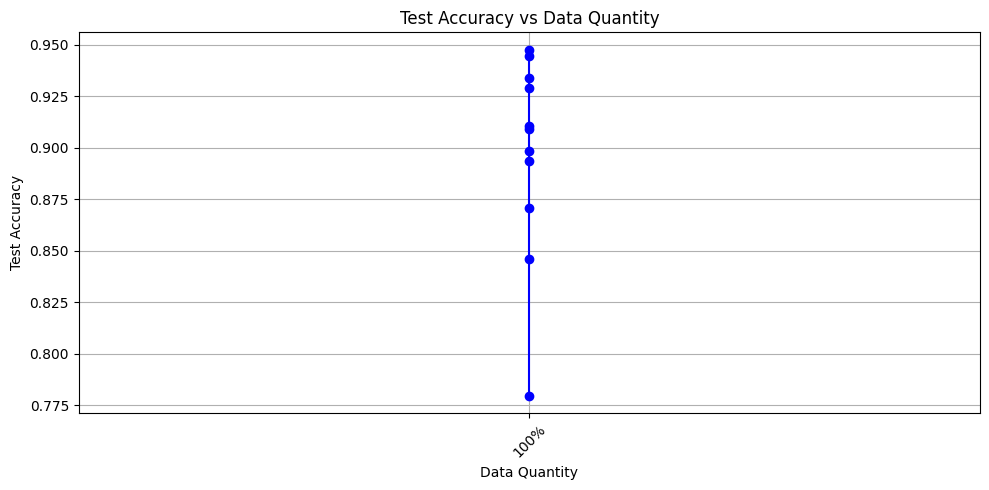

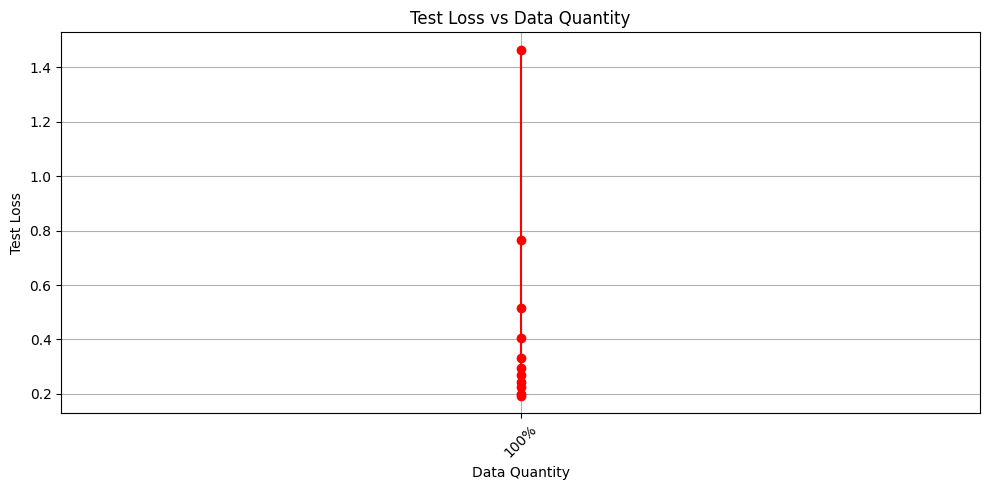

In [80]:
import matplotlib.pyplot as plt

# Prepare the data
data_quantities = [entry['data_quantity'] for entry in models_test_metrics]
test_accuracies = [entry['test_accuracy'] for entry in models_test_metrics]
test_losses = [entry['test_loss'] for entry in models_test_metrics]

# Plot Test Accuracy
plt.figure(figsize=(10, 5))
plt.plot(data_quantities, test_accuracies, marker='o', linestyle='-', color='b')
plt.title('Test Accuracy vs Data Quantity')
plt.xlabel('Data Quantity')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

# Plot Test Loss
plt.figure(figsize=(10, 5))
plt.plot(data_quantities, test_losses, marker='o', linestyle='-', color='r')
plt.title('Test Loss vs Data Quantity')
plt.xlabel('Data Quantity')
plt.ylabel('Test Loss')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.show()

NameError: name 're' is not defined